## step1: load packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from matplotlib import colors
import seaborn as sns
import statistics

# import required libraries for clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

## step2: load clean dataset

In [2]:
users = pd.read_pickle("users_date_df.pkl")
retail = pd.read_pickle("digikala_retail_cleaned.pkl")


In [3]:
print(f'users dataset :  {users.shape}, retail dataset : {retail.shape}')

users dataset :  (56104, 10), retail dataset : (199930, 11)


## Step3: Data Preparation
We are going to analysis the Customers based on below 5 factors:
- R (Recency): Number of days since last purchase
- F (Frequency): Number of tracsactions
- M (Monetary): Total amount of transactions (revenue contributed)
- L (Length): This feature is the time interval, in days, between the customer’s first and last visits
- P (Periodicity): This new feature reflects whether customers visit the stores regularly.

In [4]:
# New Attribute : Monetary

retail['Monetary']= retail['quantity']*retail['price']
rfm_m = retail.groupby('user_id')['Monetary'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.columns = ['user_id', 'Monetary']
rfm_m.head()

,user_id,Monetary
0,++2u4Q40bTeC0ZZDau1MIQ==,1082000
1,++HwHhPvBHtXEIN36fDT5w==,1414000
2,++IfjhhQ33j7i4NHdBUJkQ==,990000
3,++KPSp+1ZC6KXlYAS8VcKg==,1690500
4,++XCbp2ChGJyYhM/fYWudg==,1150000


In [5]:
# New Attribute : Frequency

rfm_f = retail.groupby('user_id')['order_id'].nunique()

rfm_f = rfm_f.reset_index()
rfm_f.columns = ['user_id', 'Frequency']
rfm_f.head()

,user_id,Frequency
0,++2u4Q40bTeC0ZZDau1MIQ==,1
1,++HwHhPvBHtXEIN36fDT5w==,1
2,++IfjhhQ33j7i4NHdBUJkQ==,1
3,++KPSp+1ZC6KXlYAS8VcKg==,1
4,++XCbp2ChGJyYhM/fYWudg==,1


In [6]:
# New Attribute : Recency
# Convert to datetime to proper datatype
retail['date'] = pd.to_datetime(retail['date'],format='%Y-%m-%d %H:%M:%S')

# Compute the maximum date to know the last transaction date
max_date = retail['date'].max()

# Compute the minimum date to know the last transaction date
min_date = retail['date'].min()

f"this df show orders for {max_date - min_date}"


'this df show orders for 8 days 17:39:43'

In [7]:
# Compute the difference between max date and transaction date
retail['Diff'] = max_date - retail['date']
retail.tail()

,order_id,user_id,variant_id,product_id,quantity,price,date,city_id,city_name,state_id,state_name,Monetary,Diff
199995,258838077,chbca7XuHDG/7OJPls3fNA==,494706,340247,1,40000,2018-08-12 06:21:26,1698,تهران,9,تهران,40000,8 days 17:37:36
199996,258838077,chbca7XuHDG/7OJPls3fNA==,823091,389988,1,325000,2018-08-12 06:21:26,1698,تهران,9,تهران,325000,8 days 17:37:36
199997,258838077,chbca7XuHDG/7OJPls3fNA==,483089,334477,1,1750000,2018-08-12 06:21:26,1698,تهران,9,تهران,1750000,8 days 17:37:36
199998,258838077,chbca7XuHDG/7OJPls3fNA==,1129695,640539,1,184000,2018-08-12 06:21:26,1698,تهران,9,تهران,184000,8 days 17:37:36
199999,258838041,OVCXfcaxQtqLzmy1U8A7eg==,1033353,568751,1,170000,2018-08-12 06:19:19,1442,بوکان,3,آذربایجان غربی,170000,8 days 17:39:43


In [8]:
# Compute last transaction date to get the recency of customers
rfm_r = retail.groupby('user_id')['Diff'].min()
rfm_r = rfm_r.reset_index()
rfm_r.columns = ['user_id', 'Recency']

In [9]:
rfm_r['Recency'] = rfm_r['Recency'].dt.days

In [10]:
rfm_r.head()

,user_id,Recency
0,++2u4Q40bTeC0ZZDau1MIQ==,0
1,++HwHhPvBHtXEIN36fDT5w==,1
2,++IfjhhQ33j7i4NHdBUJkQ==,7
3,++KPSp+1ZC6KXlYAS8VcKg==,6
4,++XCbp2ChGJyYhM/fYWudg==,8


In [11]:
# New Attribute : Length
rfm_l=retail.groupby('user_id')['date'].max()-retail.groupby('user_id')['date'].min()
rfm_l = rfm_l.reset_index()
rfm_l.columns = ['user_id', 'Length']


In [12]:
rfm_l['Length'] = rfm_l['Length'].dt.days
rfm_l.head()

,user_id,Length
0,++2u4Q40bTeC0ZZDau1MIQ==,0
1,++HwHhPvBHtXEIN36fDT5w==,0
2,++IfjhhQ33j7i4NHdBUJkQ==,0
3,++KPSp+1ZC6KXlYAS8VcKg==,0
4,++XCbp2ChGJyYhM/fYWudg==,0


In [13]:
dates_df =retail.groupby('user_id').agg(dates=('date','unique'))

In [14]:
dates_df['length_dates']=dates_df.dates.str.len()
dates_df = dates_df.reset_index()

dates_df.columns=['user_id','dates','length_dates']


In [15]:
dates_df

,user_id,dates,length_dates
0,++2u4Q40bTeC0ZZDau1MIQ==,[2018-08-20T10:57:46.000000000],1
1,++HwHhPvBHtXEIN36fDT5w==,[2018-08-19T00:13:09.000000000],1
2,++IfjhhQ33j7i4NHdBUJkQ==,[2018-08-13T20:49:22.000000000],1
3,++KPSp+1ZC6KXlYAS8VcKg==,[2018-08-14T02:52:03.000000000],1
4,++XCbp2ChGJyYhM/fYWudg==,[2018-08-12T08:02:23.000000000],1
...,...,...,...
56099,zzWZd4QWwB0L4Un+lgk/Wg==,"[2018-08-20T01:12:17.000000000, 2018-08-18T10:...",3
56100,zzZseLwyCpzXFtpz4on05Q==,"[2018-08-14T16:54:16.000000000, 2018-08-14T08:...",3
56101,zzaH+nGpEGQI2z/KZyT1GA==,[2018-08-18T23:10:21.000000000],1
56102,zzalwv4nhLscJ9Iq+HLYYw==,[2018-08-16T19:04:09.000000000],1


In [16]:
dates_df[dates_df['length_dates']==0]

,user_id,dates,length_dates


In [17]:
def order_date(x):
    if len(x) >1:
        #print(x.shape,"----------------------------")
        diff_dates = []
        x= np.asarray(sorted(x))
        for i in range(x.shape[0]):
            
            time_delta_h = (x[i+1] - x[i]).astype('timedelta64[h]').astype(int)
            time_delta_d = (x[i+1] - x[i]).astype('timedelta64[D]').astype(int)
            #print(f'{x[i+1]} - {x[i]}')
            diff_dates.append([time_delta_h,time_delta_d])
            
            if len(x) == i+2 : break
        #print(diff_dates)    
        return diff_dates
    else: return np.NAN
        
#         for i in np.ndenumerate(x):
#             print(i)

In [18]:
dates_df['diff_date_d_h']=dates_df['dates'].map(order_date)
dates_df

,user_id,dates,length_dates,diff_date_d_h
0,++2u4Q40bTeC0ZZDau1MIQ==,[2018-08-20T10:57:46.000000000],1,NaN
1,++HwHhPvBHtXEIN36fDT5w==,[2018-08-19T00:13:09.000000000],1,NaN
2,++IfjhhQ33j7i4NHdBUJkQ==,[2018-08-13T20:49:22.000000000],1,NaN
3,++KPSp+1ZC6KXlYAS8VcKg==,[2018-08-14T02:52:03.000000000],1,NaN
4,++XCbp2ChGJyYhM/fYWudg==,[2018-08-12T08:02:23.000000000],1,NaN
...,...,...,...,...
56099,zzWZd4QWwB0L4Un+lgk/Wg==,"[2018-08-20T01:12:17.000000000, 2018-08-18T10:...",3,"[[18, 0], [38, 1]]"
56100,zzZseLwyCpzXFtpz4on05Q==,"[2018-08-14T16:54:16.000000000, 2018-08-14T08:...",3,"[[47, 1], [8, 0]]"
56101,zzaH+nGpEGQI2z/KZyT1GA==,[2018-08-18T23:10:21.000000000],1,NaN
56102,zzalwv4nhLscJ9Iq+HLYYw==,[2018-08-16T19:04:09.000000000],1,NaN


In [19]:
def order_date_day_std(x):
    if len(x) >1:
        diff_dates = []
        x= np.asarray(sorted(x))
        
        for i in range(x.shape[0]):
            
            #time_delta_h = (x[i+1] - x[i]).astype('timedelta64[h]').astype(int)
            time_delta_d = (x[i+1] - x[i]).astype('timedelta64[D]').astype(int)
            diff_dates.append(time_delta_d)
            
            if len(x) == i+2 : break
        if len(diff_dates)== 1: return 0
        return statistics.stdev(diff_dates)
    else: return np.NAN
        

In [20]:
dates_df['Periodicity_day'] = dates_df['dates'].map(order_date_day_std)
dates_df

,user_id,dates,length_dates,diff_date_d_h,Periodicity_day
0,++2u4Q40bTeC0ZZDau1MIQ==,[2018-08-20T10:57:46.000000000],1,NaN,NaN
1,++HwHhPvBHtXEIN36fDT5w==,[2018-08-19T00:13:09.000000000],1,NaN,NaN
2,++IfjhhQ33j7i4NHdBUJkQ==,[2018-08-13T20:49:22.000000000],1,NaN,NaN
3,++KPSp+1ZC6KXlYAS8VcKg==,[2018-08-14T02:52:03.000000000],1,NaN,NaN
4,++XCbp2ChGJyYhM/fYWudg==,[2018-08-12T08:02:23.000000000],1,NaN,NaN
...,...,...,...,...,...
56099,zzWZd4QWwB0L4Un+lgk/Wg==,"[2018-08-20T01:12:17.000000000, 2018-08-18T10:...",3,"[[18, 0], [38, 1]]",0.000000
56100,zzZseLwyCpzXFtpz4on05Q==,"[2018-08-14T16:54:16.000000000, 2018-08-14T08:...",3,"[[47, 1], [8, 0]]",0.000000
56101,zzaH+nGpEGQI2z/KZyT1GA==,[2018-08-18T23:10:21.000000000],1,NaN,NaN
56102,zzalwv4nhLscJ9Iq+HLYYw==,[2018-08-16T19:04:09.000000000],1,NaN,NaN


In [21]:
def order_date_hour_std(x):
    if len(x) >1:
        diff_dates = []
        x= np.asarray(sorted(x))
        for i in range(x.shape[0]):
            
            time_delta_h = (x[i+1] - x[i]).astype('timedelta64[h]').astype(int)
            #time_delta_d = (x[i+1] - x[i]).astype('timedelta64[D]').astype(int)
            diff_dates.append(time_delta_h)
            
            if len(x) == i+2 : break
        if len(diff_dates)== 1: return 0
        return statistics.stdev(diff_dates)
    else: return np.NAN
        

In [22]:
dates_df['Periodicity_hour'] = dates_df['dates'].map(order_date_hour_std)
dates_df

,user_id,dates,length_dates,diff_date_d_h,Periodicity_day,Periodicity_hour
0,++2u4Q40bTeC0ZZDau1MIQ==,[2018-08-20T10:57:46.000000000],1,NaN,NaN,NaN
1,++HwHhPvBHtXEIN36fDT5w==,[2018-08-19T00:13:09.000000000],1,NaN,NaN,NaN
2,++IfjhhQ33j7i4NHdBUJkQ==,[2018-08-13T20:49:22.000000000],1,NaN,NaN,NaN
3,++KPSp+1ZC6KXlYAS8VcKg==,[2018-08-14T02:52:03.000000000],1,NaN,NaN,NaN
4,++XCbp2ChGJyYhM/fYWudg==,[2018-08-12T08:02:23.000000000],1,NaN,NaN,NaN
...,...,...,...,...,...,...
56099,zzWZd4QWwB0L4Un+lgk/Wg==,"[2018-08-20T01:12:17.000000000, 2018-08-18T10:...",3,"[[18, 0], [38, 1]]",0.000000,14.142136
56100,zzZseLwyCpzXFtpz4on05Q==,"[2018-08-14T16:54:16.000000000, 2018-08-14T08:...",3,"[[47, 1], [8, 0]]",0.000000,27.568098
56101,zzaH+nGpEGQI2z/KZyT1GA==,[2018-08-18T23:10:21.000000000],1,NaN,NaN,NaN
56102,zzalwv4nhLscJ9Iq+HLYYw==,[2018-08-16T19:04:09.000000000],1,NaN,NaN,NaN


In [23]:
# Merging the two dfs

rfm = pd.merge(rfm_m, rfm_f, on='user_id', how='inner')
rfm.head()

,user_id,Monetary,Frequency
0,++2u4Q40bTeC0ZZDau1MIQ==,1082000,1
1,++HwHhPvBHtXEIN36fDT5w==,1414000,1
2,++IfjhhQ33j7i4NHdBUJkQ==,990000,1
3,++KPSp+1ZC6KXlYAS8VcKg==,1690500,1
4,++XCbp2ChGJyYhM/fYWudg==,1150000,1


In [24]:
rfm = pd.merge(rfm, rfm_r, on='user_id', how='inner')
# rfm.rename(columns={"Diff": "Recency"})
rfm

,user_id,Monetary,Frequency,Recency
0,++2u4Q40bTeC0ZZDau1MIQ==,1082000,1,0
1,++HwHhPvBHtXEIN36fDT5w==,1414000,1,1
2,++IfjhhQ33j7i4NHdBUJkQ==,990000,1,7
3,++KPSp+1ZC6KXlYAS8VcKg==,1690500,1,6
4,++XCbp2ChGJyYhM/fYWudg==,1150000,1,8
...,...,...,...,...
56099,zzWZd4QWwB0L4Un+lgk/Wg==,4981000,3,0
56100,zzZseLwyCpzXFtpz4on05Q==,1560000,3,6
56101,zzaH+nGpEGQI2z/KZyT1GA==,3630000,1,2
56102,zzalwv4nhLscJ9Iq+HLYYw==,1570000,1,4


In [25]:
rfm = pd.merge(rfm, rfm_l, on='user_id', how='inner')


In [26]:
rfm =pd.merge(rfm, dates_df[['user_id','Periodicity_day','Periodicity_hour']], on='user_id', how='inner')

In [27]:
rfm = rfm.drop('index', 1)

KeyError: "['index'] not found in axis"

In [28]:
rfm

,user_id,Monetary,Frequency,Recency,Length,Periodicity_day,Periodicity_hour
0,++2u4Q40bTeC0ZZDau1MIQ==,1082000,1,0,0,NaN,NaN
1,++HwHhPvBHtXEIN36fDT5w==,1414000,1,1,0,NaN,NaN
2,++IfjhhQ33j7i4NHdBUJkQ==,990000,1,7,0,NaN,NaN
3,++KPSp+1ZC6KXlYAS8VcKg==,1690500,1,6,0,NaN,NaN
4,++XCbp2ChGJyYhM/fYWudg==,1150000,1,8,0,NaN,NaN
...,...,...,...,...,...,...,...
56099,zzWZd4QWwB0L4Un+lgk/Wg==,4981000,3,0,2,0.000000,14.142136
56100,zzZseLwyCpzXFtpz4on05Q==,1560000,3,6,2,0.000000,27.568098
56101,zzaH+nGpEGQI2z/KZyT1GA==,3630000,1,2,0,NaN,NaN
56102,zzalwv4nhLscJ9Iq+HLYYw==,1570000,1,4,0,NaN,NaN


In [29]:
rfm[rfm['Frequency']!=1]

,user_id,Monetary,Frequency,Recency,Length,Periodicity_day,Periodicity_hour
7,++aFMHHDKluZF2DJXQ4VVg==,880000,2,5,2,0.000000,0.000000
8,++fz+vTHQnkgPIU4nFLwqg==,7021000,2,0,0,0.000000,0.000000
14,+/4x52C5GE58tU5a4oiIoA==,19120000,3,1,3,0.000000,7.071068
38,+0NLplvuXBK8B57SSP/BPw==,7290000,2,0,0,0.000000,0.000000
39,+0PlX9fbkOLljCIpz6XPLw==,1528800,2,3,4,0.000000,0.000000
...,...,...,...,...,...,...,...
56085,zyNlyJ683PXoh2J3+EoVzA==,3183000,3,3,3,0.000000,25.455844
56087,zyW1Qg/kCiCypSrcH8+51A==,2155000,2,7,0,0.000000,0.000000
56099,zzWZd4QWwB0L4Un+lgk/Wg==,4981000,3,0,2,0.000000,14.142136
56100,zzZseLwyCpzXFtpz4on05Q==,1560000,3,6,2,0.000000,27.568098


In [30]:
attributes = ['Monetary','Frequency','Recency','Length','Periodicity_day']

Text(0.5, 0, 'Attributes')

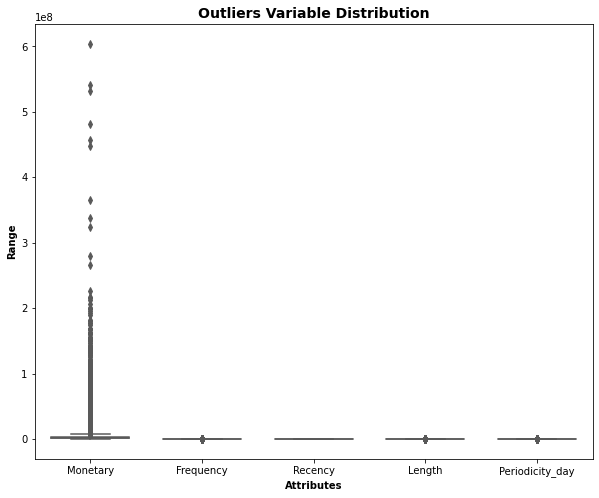

In [31]:
# Outlier Analysis of Amount Frequency and Recency


plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [32]:
# Removing (statistical) outliers for Amount
for attribute in attributes:
    Q1 = rfm[attribute].quantile(0.05)
    Q3 = rfm[attribute].quantile(0.95)
    IQR = Q3 - Q1
    rfm = rfm[(rfm[attribute] >= Q1 - 1.5*IQR) & (rfm[attribute] <= Q3 + 1.5*IQR)]

In [33]:
rfm['Frequency'].unique()

array([2, 3, 4, 5, 6], dtype=int64)

In [34]:
rfm_df = rfm[attributes]

In [35]:
rfm_df

,Monetary,Frequency,Recency,Length,Periodicity_day
7,880000,2,5,2,0.000000
8,7021000,2,0,0,0.000000
14,19120000,3,1,3,0.000000
38,7290000,2,0,0,0.000000
39,1528800,2,3,4,0.000000
...,...,...,...,...,...
56085,3183000,3,3,3,0.000000
56087,2155000,2,7,0,0.000000
56099,4981000,3,0,2,0.000000
56100,1560000,3,6,2,0.000000


In [36]:
# Instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(9929, 5)

In [37]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = attributes
rfm_df_scaled.head()

,Monetary,Frequency,Recency,Length,Periodicity_day
0,-0.854967,-0.535788,1.165766,-0.206913,-0.389685
1,0.119723,-0.535788,-1.077343,-1.071576,-0.389685
2,2.040058,0.658607,-0.628721,0.225418,-0.389685
3,0.162418,-0.535788,-1.077343,-1.071576,-0.389685
4,-0.751991,-0.535788,0.268522,0.657750,-0.389685


## Step 3 : Building the Model

In [38]:
# k-means with some arbitrary k

kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [39]:
kmeans.labels_

array([0, 1, 3, ..., 1, 0, 2])

In [40]:
rfm['Cluster_Id'] = kmeans.labels_
rfm.head()

,user_id,Monetary,Frequency,Recency,Length,Periodicity_day,Periodicity_hour,Cluster_Id
7,++aFMHHDKluZF2DJXQ4VVg==,880000,2,5,2,0.0,0.000000,0
8,++fz+vTHQnkgPIU4nFLwqg==,7021000,2,0,0,0.0,0.000000,1
14,+/4x52C5GE58tU5a4oiIoA==,19120000,3,1,3,0.0,7.071068,3
38,+0NLplvuXBK8B57SSP/BPw==,7290000,2,0,0,0.0,0.000000,1
39,+0PlX9fbkOLljCIpz6XPLw==,1528800,2,3,4,0.0,0.000000,1


<AxesSubplot:xlabel='Cluster_Id', ylabel='Monetary'>

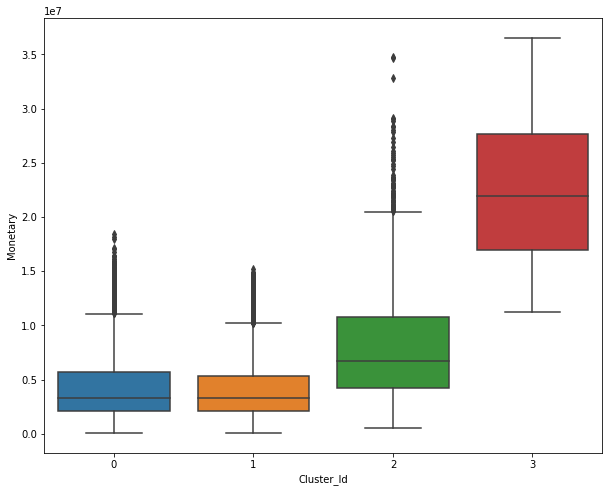

In [41]:
# Box plot to visualize Cluster Id vs Frequency

sns.boxplot(x='Cluster_Id', y='Monetary', data=rfm)

<AxesSubplot:xlabel='Cluster_Id', ylabel='Frequency'>

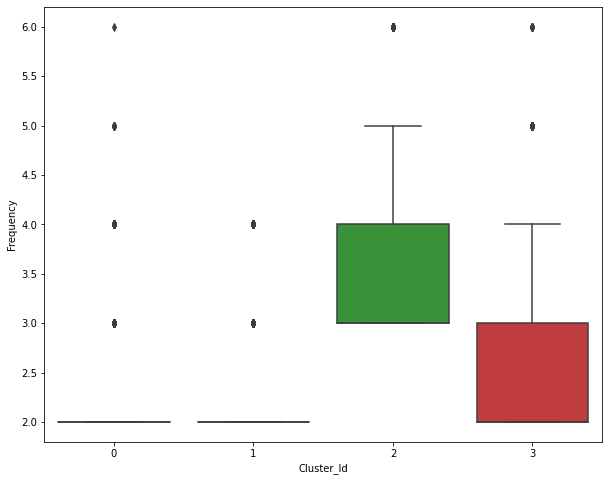

In [42]:
# Box plot to visualize Cluster Id vs Frequency

sns.boxplot(x='Cluster_Id', y='Frequency', data=rfm)

<AxesSubplot:xlabel='Cluster_Id', ylabel='Length'>

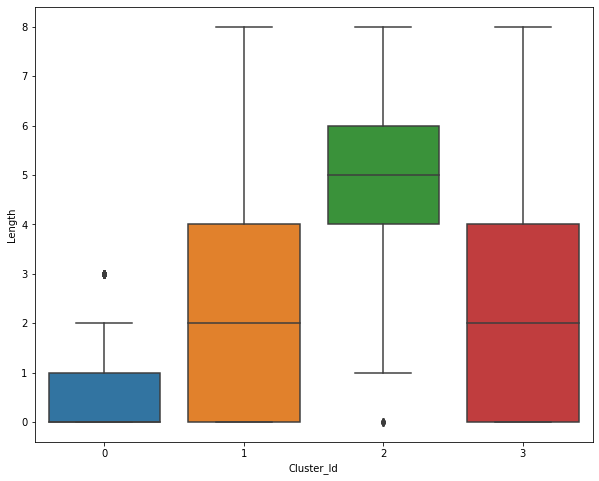

In [43]:
# Box plot to visualize Cluster Id vs Frequency

sns.boxplot(x='Cluster_Id', y='Length', data=rfm)

In [44]:
from hmmlearn import hmm


In [45]:
lrfmp = rfm[['Monetary','Frequency','Recency','Length','Periodicity_day']]

In [46]:
model = hmm.MultinomialHMM(n_components=2, n_iter=50, tol=0.001)
model.startprob_=np.array([0.5, 0.5])
model.fit(np.array(lrfmp.astype('int')))

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Fitting a model with 73060003 free scalar parameters with only 49645 data points will result in a degenerate solution.


KeyboardInterrupt: 

In [ ]:
print('startprob', np.round(model.startprob_,3))
print('transmat', np.round(model.transmat_,3))
print('emissionprob', np.round(model.emissionprob_,3))


In [47]:
print('score', model.score(np.array(lrfmp.astype('int'))))

score -179108.1941293678


In [48]:
lrfmp['Frequency'].value_counts()

2    7071
3    1794
4     656
5     284
6     124
Name: Frequency, dtype: int64

In [49]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# fit_transform
lrfmp_df_scaled = scaler.fit_transform(lrfmp)
lrfmp_df_scaled.shape

(9929, 5)

In [50]:
lrfmp_df_scaled = pd.DataFrame(lrfmp_df_scaled)
lrfmp_df_scaled.columns = ['Monetary', 'Frequency', 'Recency','Length','Periodicity_day']
lrfmp_df_scaled.head()

,Monetary,Frequency,Recency,Length,Periodicity_day
0,-0.854967,-0.535788,1.165766,-0.206913,-0.389685
1,0.119723,-0.535788,-1.077343,-1.071576,-0.389685
2,2.040058,0.658607,-0.628721,0.225418,-0.389685
3,0.162418,-0.535788,-1.077343,-1.071576,-0.389685
4,-0.751991,-0.535788,0.268522,0.657750,-0.389685


In [51]:
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
mergings = linkage(lrfmp_df_scaled, method="complete", metric='euclidean')
# dendrogram(mergings)
# plt.show()


In [52]:
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
model = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
model.fit(lrfmp_df_scaled)
labels = model.labels_

In [53]:
from sklearn.metrics import silhouette_samples, silhouette_score
silhouette_avg = silhouette_score(lrfmp_df_scaled, labels)
silhouette_avg

0.28417049056394866

In [54]:
#  #! pip install yellowbrick
# from yellowbrick.cluster import SilhouetteVisualizer


# fig, ax = plt.subplots(2, 2, figsize=(15,8))
# for i in [2, 3, 4, 5]:
#     '''
#     Create KMeans instance for different number of clusters
#     '''
#     model = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
#     q, mod = divmod(i, 2)
#     '''
#     Create SilhouetteVisualizer instance with KMeans instance
#     Fit the visualizer
#     '''
#     visualizer = SilhouetteVisualizer(model, colors='yellowbrick', ax=ax[q-1][mod])
#     visualizer.fit_predict(lrfmp_df_scaled)

In [62]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import NearestCentroid


In [73]:
def clustering(df1):
    X = df1.iloc[:].values
    range_n_clusters = [2,3,4,6,8]
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        clusterer = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
        y_predict = clusterer.fit_predict(X)
        cluster_labels = clusterer.labels_

        clf = NearestCentroid()
        clf.fit(X, y_predict)
        print("Centroids:")
        print(clf.centroids_)

        silhouette_avg = silhouette_score(X, cluster_labels)
#         if silhouette_avg > 0.4:
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)
        fig, (ax1,ax2) = plt.subplots(1, 2)

        fig.set_size_inches(15, 5)

        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10  # 10 for the 0 samples

            ax1.set_title("The silhouette plot for the various clusters.")
            ax1.set_xlabel("The silhouette coefficient values")
            ax1.set_ylabel("Cluster label")
            ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

            ax1.set_yticks([])  # Clear the yaxis labels / ticks
            ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
#             ax = Axes3D(fig)
#             colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
#             ax.scatter(X[:, 1], X[:, 2], X[:, 0],marker='o', s=20, lw=0, alpha=0.7,
#                         c=colors, edgecolor='k')

            plt.suptitle(("Silhouette analysis for HAC-ward clustering on sample data "
                          "with n_clusters = %d" % n_clusters),
                         fontsize=14, fontweight='bold')
    plt.show()

    return

Centroids:
[[-0.12919965 -0.33760008  0.11177971 -0.21263499 -0.38714884]
 [ 0.59596899  1.55727342 -0.51561471  0.98083749  1.78583073]]
For n_clusters = 2 The average silhouette_score is : 0.43615075166997724
Centroids:
[[ 0.22051154 -0.40030016 -0.48840334  0.80360611 -0.38968514]
 [ 0.59596899  1.55727342 -0.51561471  0.98083749  1.78583073]
 [-0.30444124 -0.30618084  0.41253369 -0.72187722 -0.38587789]]
For n_clusters = 3 The average silhouette_score is : 0.28417049056394866
Centroids:
[[-0.30444124 -0.30618084  0.41253369 -0.72187722 -0.38587789]
 [ 0.59596899  1.55727342 -0.51561471  0.98083749  1.78583073]
 [-0.27682462 -0.41687669 -0.57849935  0.99156321 -0.38968514]
 [ 2.64288166 -0.319561   -0.04957362 -0.11187459 -0.38968514]]
For n_clusters = 4 The average silhouette_score is : 0.2802925697994404
Centroids:
[[-0.32868505 -0.20801908 -0.10505417 -0.66217789 -0.38425021]
 [ 0.10205973  1.0058154  -0.5079957   1.02508786  2.27419112]
 [ 1.64847651  2.73241582 -0.53185062  0.8

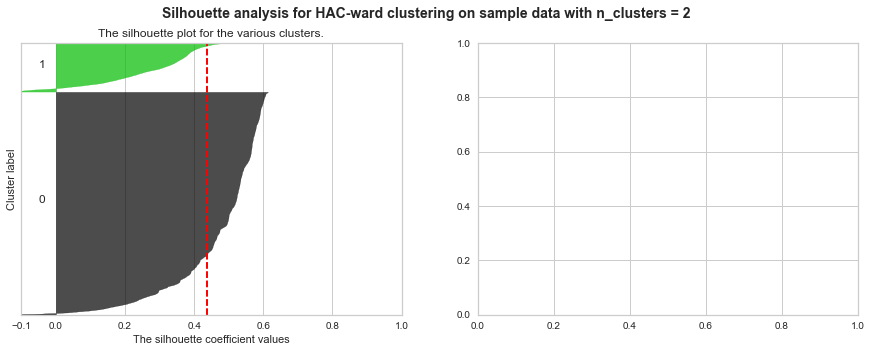

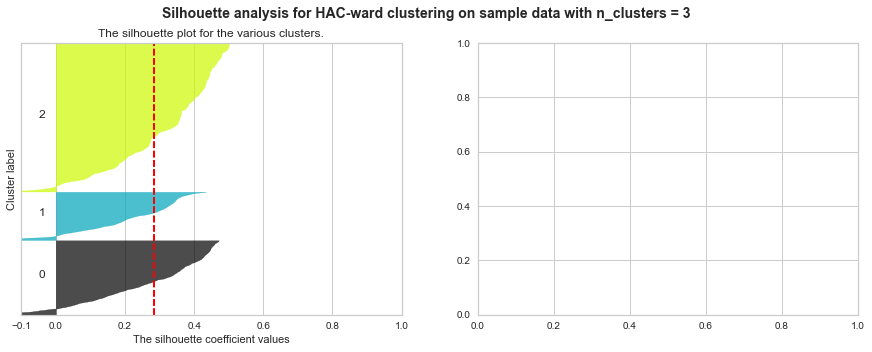

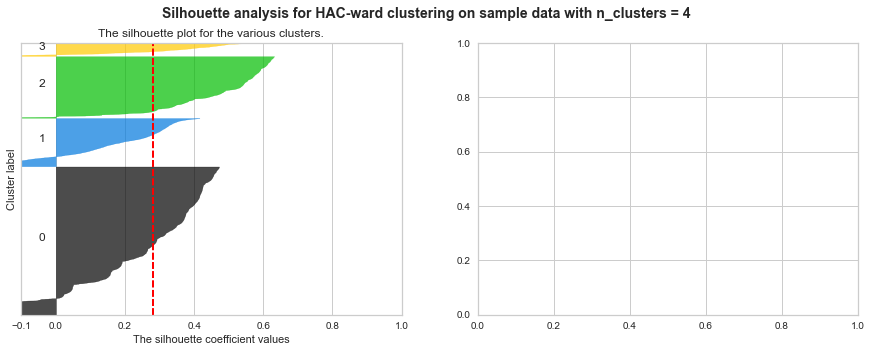

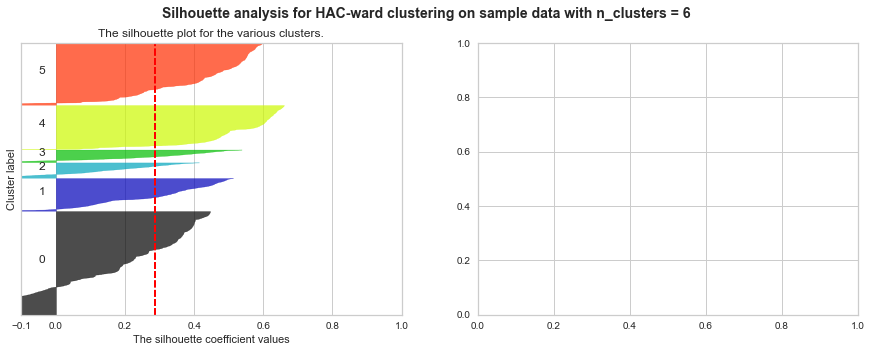

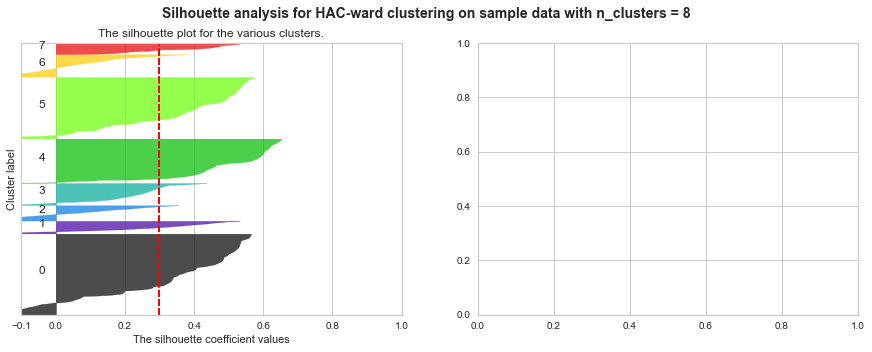

In [74]:
clustering(lrfmp_df_scaled)
# refrence   
# https://dzone.com/articles/kmeans-silhouette-score-explained-with-python-exam
# https://gist.github.com/bitsnaps/12415200fc62539fff852a1b46168d0a

In [ ]:
from sklearn.metrics import pairwise_distances
# Your method to calculate distance between two samples
def sim(x, y): 
    return np.sum(np.equal(np.array(x), np.array(y)))/len(x)


# Method to calculate distances between all sample pairs

def sim_affinity(X):
    return pairwise_distances(X, metric=sim)

# cluster = AgglomerativeClustering(n_clusters=3, affinity=sim_affinity, linkage='average')
# cluster.fit(lrfmp_df_scaled)

In [ ]:
from scipy.spatial import distance
def dtw(a, b):   
    an = a.size
    bn = b.size
    pointwise_distance = distance.cdist(a.reshape(-1,1),b.reshape(-1,1))
    cumdist = np.matrix(np.ones((an+1,bn+1)) * np.inf)
    cumdist[0,0] = 0
    
    for ai in range(an):
        for bi in range(bn):
            minimum_cost = np.min([cumdist[ai, bi+1],
                                   cumdist[ai+1, bi],
                                   cumdist[ai, bi]])
            cumdist[ai+1, bi+1] = pointwise_distance[ai,bi] + minimum_cost

    return cumdist[an, bn]

def dtw_affinity(X):
    return pairwise_distances(X, metric=dtw)

# cluster = AgglomerativeClustering(n_clusters=3, affinity='precomputed', linkage='average')
# cluster.fit(lrfmp_df_scaled)


In [ ]:
# # Test symmetric matrix
# N = 4
# # b = np.random.randint(0,5,size=(N,N))
# b_symm = (lrfmp_df_scaled + lrfmp_df_scaled.T)/2
# # np.fill_diagonal(b_symm,np.zeros(lrfmp_df_scaled.shape))
# model = AgglomerativeClustering(n_clusters=3, affinity='precomputed', linkage='average')
# y = model.fit_predict(b_symm)